An example of the necissity/utility of a ordered cross validation plan (especially for time-oriented data).

For this example we are given as our problem try to learn `y = f(x)` from training data.  Our
data will be noisy evaluations of the function evaluation.  We will use some of this data for training, and
reserve some of the data for test.  The test data is not used for any fitting or decision step in the example, 
it is only used to be shown in the graphs and to help the reader evaluate the quality of the fit.

In addition to comparing the fit function to both observed training data and unobserved test data, we
also show the ideal (noise-free) concept for both the region we drew data from and for a small interval outside
the observable region.  This shows us some of the difficulty of the harder problems of generalization (learning an
approximation of the concept, instead of just memorizing relations seen in the training data) and the harder
problem of extrapolation (being a reliable approximation outside of the observable region).



In [16]:
import functools
import operator
import pygam
import pandas
import math
import numpy
import seaborn
import matplotlib
import matplotlib.pyplot
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import vtreat.cross_plan


Make an example concept to learn: `y ~ sin(1.1*x)`.  All calculations will be made only using `dtrain` which is a random 
subset of the available data (leaving us a test or holdout set to show to the reader) and on noise observations 
(the noise-free ideal concept is not seen by the fitting procedures).

In [17]:
numpy.random.seed(seed=2018)

def mk_example(minv, maxv, step):
    d = pandas.DataFrame({'x': numpy.arange(minv, maxv, step)})
    d['y_theoretical'] = [math.sin(1.1*x) for x in d['x']]
    return(d)
    
d = mk_example(0, 15, 0.2)
d['y'] = d['y_theoretical'] + 0.2*numpy.random.normal(0,1,len(d['y_theoretical']))
d['train'] = numpy.random.uniform(0,1,len(d['y_theoretical']))>=0.5

dtrain = d[d['train']].copy()
dtrain.reset_index(inplace=True, drop=True)
dexpanded = mk_example(-5, 20, 0.1)
d.head()

,x,y_theoretical,y,train
0,0.0,0.000000,-0.055354,False
1,0.2,0.218230,0.334600,False
2,0.4,0.425939,0.855619,False
3,0.6,0.613117,0.357219,False
4,0.8,0.770739,0.871194,True


Let's plot all of: the ideal concept, the ideal condept out of the observable region, the training data, 
and the test data.

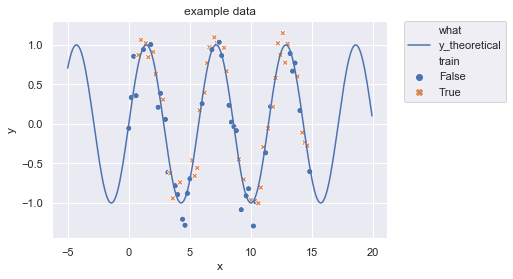

In [18]:
def plotf(dpts, dcurves, curves, title):
    seaborn.set(style="darkgrid")
    pd = dcurves.loc[:, ["x"] + curves]
    pd = pd.set_index("x")
    pd = pandas.DataFrame.unstack(pd)
    pd = pd.reset_index()
    pd = pd.rename(columns={"level_0": "what", "x": "x", 0:"y"})
    matplotlib.pyplot.clf()
    seaborn.lineplot(x="x", y="y", hue="what", data=pd)
    seaborn.scatterplot(x="x", y="y", hue="train", style="train", data=dpts)
    matplotlib.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.show()
    
plotf(d, dexpanded, ["y_theoretical"], "example data")

Use the GAM methodoloy to fit a model using only the training data and plot the results.

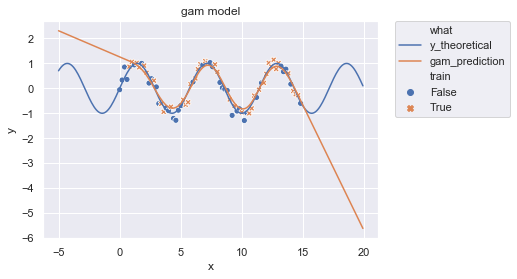

In [19]:
model = pygam.LinearGAM().fit(dtrain[['x']], dtrain['y'])

dexpanded['gam_prediction'] = model.predict(dexpanded[['x']])

plotf(d, dexpanded, ["y_theoretical", "gam_prediction"], "gam model")

Notice the GAM fit is very good inside the observed region, but linearly extrapolates outside of this region.
This is a reasonable extrapolation, but not good enough for our application.

Now we apply some domain knowledge and decide to fit this relation as a linear combination of periodic functions.
To do this we just enter a number of functions of different periods/frequencies and phases.  
Notice we deliberately did not enter the actual function `sin(1.1*x)`, this is to simulate the real-world
situation of not in fact knowing the exact answer before starting fitting.


In [20]:
vars = []
for freq in [0.1, 0.25, 0.5, 1.0, 2.0, 4, 10]:
    for phase in [freq*offset for offset in [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]]:
        vi = "sin((x+" + str(phase) + ")*" + str(freq) + ")"
        dexpanded[vi] = [ math.sin((x+phase)*freq) for x in dexpanded["x"] ]
        dtrain[vi] = [ math.sin((x+phase)*freq) for x in dtrain["x"] ]
        vars = vars + [vi]

dtrain.head()

,x,y_theoretical,y,train,sin((x+-0.1)*0.1),sin((x+-0.05)*0.1),sin((x+-0.025)*0.1),sin((x+0.0)*0.1),sin((x+0.025)*0.1),sin((x+0.05)*0.1),...,sin((x+1.0)*4),sin((x+2.0)*4),sin((x+4)*4),sin((x+-10)*10),sin((x+-5.0)*10),sin((x+-2.5)*10),sin((x+0)*10),sin((x+2.5)*10),sin((x+5.0)*10),sin((x+10)*10)
0,0.8,0.770739,0.871194,True,0.069943,0.074930,0.077422,0.079915,0.082406,0.084898,...,0.793668,-0.979178,0.343315,0.779466,0.916522,0.961397,0.989358,0.999912,0.992873,0.926819
1,1.0,0.891207,1.062413,True,0.089879,0.094857,0.097346,0.099833,0.102321,0.104807,...,0.989358,-0.536573,0.912945,-0.893997,-0.745113,-0.650288,-0.544021,-0.428183,-0.304811,-0.044243
2,1.4,0.999526,1.021542,True,0.129634,0.134590,0.137067,0.139543,0.142018,0.144492,...,-0.174327,0.859162,0.381250,0.923458,0.991779,0.999990,0.990607,0.963795,0.920026,0.784980
3,1.6,0.982154,0.844541,True,0.149438,0.154380,0.156850,0.159318,0.161786,0.164252,...,-0.827826,0.965658,-0.397556,-0.733190,-0.529083,-0.412118,-0.287903,-0.158623,-0.026551,0.236661
4,2.0,0.808496,0.910541,True,0.188859,0.193767,0.196219,0.198669,0.201119,0.203567,...,-0.536573,-0.287903,-0.905578,0.993889,0.988032,0.958924,0.912945,0.850904,0.773891,0.580611


We will use elastic-net regularized regression. This means there are two hyper-paramaters controlling
the amount of regularization and the reliance on an L1 versus L2 regularization penalty.
We will try to find good values of these regularization parameters with a standard random k-way cross validation plan.
In all cases the cross-validation is only over subsets of the training data, no test data is used.
Also the regularization is used only to find the two regularization parameters, the final model fit is simply
performed on the training data as before.

We will search the following grid for the hyper parameters.

In [21]:
alphas = [ 10 ** k for k in range(-3, 3, 1) ]
l1_ratios = numpy.arange(0, 1, 0.1)
grid = [ [ {"alpha": alpha, "l1_ratio": l1_ratio} for alpha in alphas ] for l1_ratio in l1_ratios ]
grid = functools.reduce(operator.concat, grid)
grid[0]

{'alpha': 0.001, 'l1_ratio': 0.0}

In [22]:
def cross_predict_model(fitter, X, Y, plan):
    preds = numpy.zeros(X.shape[0])
    for g in range(len(plan)):
        pi = plan[g]
        model = fitter.fit(X.iloc[pi["train"]], Y.iloc[pi["train"]])
        predg = model.predict(X.iloc[pi["app"]])
        preds[pi["app"]] = predg
    return preds

def est_quality(settings, plan):
    fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], 
                                             l1_ratio = settings["l1_ratio"], fit_intercept=True)
    preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
    mean_sq_error = numpy.mean((dtrain['y'] - preds)**2)
    return mean_sq_error

In [23]:
%%capture
k_way_plan = vtreat.cross_plan.k_way_cross_plan(n_rows=dtrain.shape[0], k_folds=5)
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, k_way_plan)} for settings in grid ]

In [24]:
min_loss = numpy.min([ q["loss"] for q in param_evals ])
best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'settings': {'alpha': 0.001, 'l1_ratio': 0.0}, 'loss': 0.05927056861189515}]

Now that we have picked our best hyper-parameters we use them plus the training data to fit a model on the training data.

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7340904141036223, tolerance: 0.001997642400668087
  positive)


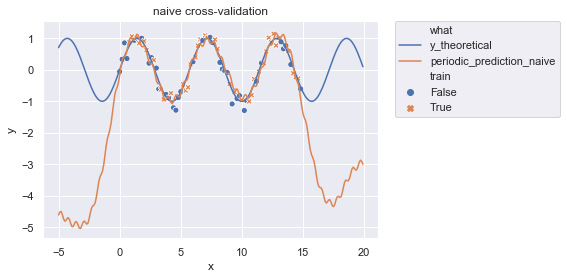

In [25]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction_naive'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction_naive"], "naive cross-validation")

Notice the model fit is quite good in the region of the observed training data, but is very bad outside of
this region. It fails to reliably extrapolate.  This is because in a typical random cross-validation plan most of the test
poins are between training points.  So such a plan evaluates and emphasizes interpolation quality.


The model coefficients are given below.

In [26]:
print(model.intercept_)
print(model.coef_)

-1.9743736124301823
[ 1.63095907e-01  1.69234039e-01  1.71094885e-01  1.69396322e-01
  1.66607614e-01  1.65254173e-01  1.66215756e-01  2.02068269e-01
  2.04249966e-01  3.04200633e-01  4.11747886e-01  4.41090990e-01
  3.71250529e-01  2.32817403e-01 -1.50055467e+00 -1.04542323e+00
 -5.15504719e-01  1.86344502e-01  7.38123512e-01  1.03942755e+00
  1.48142727e+00 -2.36751448e-01 -7.21891411e-02  9.97076797e-02
  2.43120113e-01  3.10926378e-01  3.23118432e-01  3.46878863e-01
  2.20546703e-03 -5.96327325e-03 -3.63637463e-03  3.21767698e-03
  8.16366415e-03  4.60526730e-03 -5.44240978e-03  6.45861302e-03
 -3.21375517e-03  7.17212770e-03 -7.05755151e-03  9.24367386e-04
  4.73842493e-03  3.74321921e-03 -3.07959113e-02 -1.37652179e-02
  2.72818935e-03  2.04638595e-02  3.19578332e-02  3.68496130e-02
  4.69762369e-02]


Notice how the fit was produced by combining all of the basis functions in a way that happens to match the data in the training region, but obviously fails outside of that region.

Now let's try the same process with an ordered cross-validation plan. Our ordered plan is designed so evaluation points are intervals (no training points are between evaluation points) and all training points are to one side of the evaluation poins (no evaluation points between training points).  This attempts to emphasize the ability to extrapolate as the cross-validation evaluation standard.  An example of how these order plans look can be found [here](https://github.com/WinVector/pyvtreat/blob/master/Examples/OrderedCrossPlan/OrderedCrossPlan.ipynb).

In [27]:
%%capture
ordered_plan = vtreat.cross_plan.order_cross_plan(k_folds=5, order_vector=dtrain['x'])
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, ordered_plan)} for settings in grid ]

In [28]:
min_loss = numpy.min([ q["loss"] for q in param_evals ])
best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'settings': {'alpha': 0.1, 'l1_ratio': 0.9}, 'loss': 0.2554900300865486}]

Now we fit a new model on training data.  All this is different is the selected values of the regularization hyper-parameters.  These new values are more regularization (`alpha` is much larger) and more `L1` penality.  Compared to the earlier hyper-parameters these hyper-parameters are valuing model simplicity (small coefficients and few non-zero coefficients) over quality of fit in the cross-validated training regions.

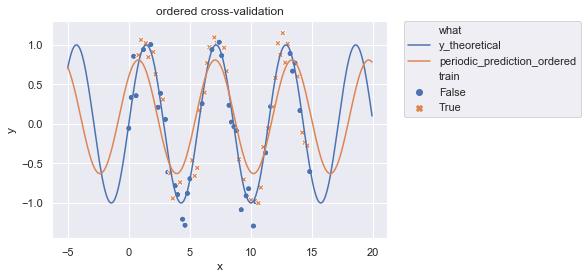

In [29]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction_ordered'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction_ordered"], "ordered cross-validation")

Notice how the model, calibrated and trained only on the training subset of the training interval is somewhat close to all training
and hold out data *and* a plausible shape outside of the training region!  We got a plausible extrapolation (which is asking a lot). We traded some quality of fit for model simplicity and plausible extrapolation.

Below we share the coefficients of the new model. Notice, due to the stronger regularization, how it only used a couple of the basis functions.

In [30]:
print(model.intercept_)
print(model.coef_)

0.09021584261690893
[-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.
  0.          0.          0.30843575  0.43240539  0.         -0.
 -0.          0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
